In [282]:
class McDonald_Word_List:
    def __init__(self, pos_words, neg_words):
        self.pos_words = pos_words
        self.neg_words = neg_words
        self.pos_word_counts = {word:0 for word, val in pos_words.items()}
        self.intersection_pos = {word:0 for word, val in pos_words.items()}
        self.neg_word_counts = {word:0 for word, val in neg_words.items()}
        self.intersection_neg = {word:0 for word,val in neg_words.items()}
        
    def __str__(self):
        print("""Pos words: {0}
                 Neg words: {1}""".format(
                  len(self.pos_words),
                  len(self.neg_words)))

We will now read the Bill McDonald's Excel file containing the master dictionary of financial sentiment words.
For this task, I am using the xlrd library. For now, I am only reading the cell values that have words with positive or negative sentiment.

In [283]:
from xlrd import open_workbook
FORMAT = ['Positive', 'Negative']
values = ""

wb = open_workbook('McDonaldDict.xlsx')

values = []
for s in wb.sheets():
    #print 'Sheet:',s.name
    words = []
    pos = {}
    neg = {}
    for row in range(1, s.nrows):
        col_names = s.row(0)[1:]
        col_value = []
        word = s.cell(row, 0).value
        for name, col in zip(col_names, range(1,s.ncols)):
            value  = (s.cell(row,col).value)
            if name.value == 'Positive' and int(value) > 0:
                pos[word] = int(value)
            elif name.value == 'Negative' and int(value) > 0:
                neg[word] = int(value)
            col_value.append((name.value, value))
        values.append(col_value)
mcd = McDonald_Word_List(pos, neg)
print(mcd.pos_words)

{'PROGRESSES': 2009, 'DELIGHT': 2009, 'BOLSTERS': 2009, 'ACCOMPLISH': 2009, 'IMPROVES': 2009, 'BOOSTED': 2009, 'PREMIER': 2009, 'CONFIDENT': 2009, 'BENEFITED': 2009, 'ENJOYS': 2009, 'EMPOWERED': 2009, 'INVENTIVENESS': 2009, 'EFFICIENTLY': 2009, 'COLLABORATED': 2009, 'SATISFACTORILY': 2009, 'ENJOYABLY': 2009, 'BEST': 2012, 'PREEMINENCE': 2009, 'BENEFIT': 2009, 'PROSPERING': 2009, 'INVENTED': 2009, 'ENJOY': 2009, 'ACHIEVE': 2009, 'INNOVATORS': 2009, 'PLEASED': 2009, 'ADVANTAGED': 2009, 'OUTPERFORM': 2009, 'POPULAR': 2009, 'DISTINCTIVENESS': 2009, 'REGAINING': 2009, 'DEPENDABILITY': 2009, 'DELIGHTFULLY': 2009, 'SOLVES': 2009, 'INSIGHTFUL': 2009, 'REVOLUTIONIZING': 2009, 'LEADING': 2009, 'EXCELLENCE': 2009, 'FAVORABLY': 2009, 'DESTINED': 2009, 'ACCOMPLISHES': 2009, 'ACHIEVEMENT': 2009, 'WINNING': 2009, 'REVOLUTIONIZED': 2009, 'PERFECTED': 2009, 'EXCELS': 2009, 'COMPLIMENTING': 2009, 'PROSPERS': 2009, 'EASY': 2009, 'EFFICIENCIES': 2009, 'FAVORITES': 2009, 'DESIRABLE': 2009, 'IMPRESSIVELY': 

Voila. We have our lists of positive and negative words generated. These words were annotated for the financial domain and will be what we use to analyze our pointwise mutual information across the corpus.

In [184]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def create_co_occurrence_matrix(sentences):
    words = []
    for sentence in sentences:
        words.extend(nltk.word_tokenize(sentence))
        
    #for w, k in zip(words, range(len(words))):
    #    print(str(w) + ' ' + str(k))
    count = 0
    pairs = {}
    for word in words:
        if word not in pairs:
            pairs[word] = count
            count += 1
    ngram_vectorizer = CountVectorizer(ngram_range=(5,5))
    print(sentences[1])
    X = ngram_vectorizer.fit_transform(sentences)
    
    Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
    #print(Xc)
    Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
    print(Xc.todense()) 
    names = X.columns.values[ngram_vectorizer.get_support()]
    
    """co_occurrences = ngram_vectorizer.fit_transform(words)
    sum_occ = np.sum(co_occurrences.todense(),axis=0)
    # print(sum_occ)
    print ('Pretty printing of co_occurrences count:', list(zip(ngram_vectorizer.get_feature_names())),np.array(sum_occ)[0].tolist())"""
    return sum_occ

In [254]:
import os
path = os.getcwd()

reuters_folders = os.listdir('/home/jmkovachi/Documents/jupyter_notebooks/reuters')[0:10]

path += '/reuters'

articles = []
for folder in reuters_folders:
    article_files = os.listdir(path + '/' + folder)
    for file in article_files:
        with open(path + '/' + folder + '/' + file) as f:
            articles.append(f.read())



474


We use this code above to open up our Reuters folder and read the files from our directory. The data being used here comes from this repository [financial news corpus](https://github.com/philipperemy/financial-news-dataset). It is pretty great. 

In [194]:
import requests

data = [
  ('pfreq', '1'),
  ('apikey', 'aikiz3Bel9'),
  ('nex', '1'),
  ('url', 'https://raw.githubusercontent.com/philipperemy/financial-news-dataset/master/ReutersNews106521/20061020/businesspro-google-dc-idUSN2036351320061020'),
]

response = requests.post('http://cyn.io/api/', data=data)
#print(response.text)

In [201]:
from nltk.chunk import conlltags2tree, tree2conlltags

sentence = "Mark and John are working at Google."

for sent in nltk.sent_tokenize(sentence):
   for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
      if hasattr(chunk, 'label'):
         print(chunk.label(), ' '.join(c[0] for c in chunk))

PERSON Mark
PERSON John
ORGANIZATION Google


Above is some example code from nltk's NE chunker/tagger. It works quite well in our purposes for this PMI task.

Below is where I get into the meat of calculating the PMI. 

$$pmi(x,y) = log\frac{p(x,y)}{p(x)p(y)}$$

Usually we define p(x,y) as the probability of the intersection of two entities within some window. For the purposes of this experiment, I am defining windows as sentences. Therefore, the equation we arrive for calculating PMI at is:

$$pmi(x,y) = log\frac{count(x,y)_{D}}{count(x)_{D}count(y)_{D}}$$

Where $$D$$ is all of the documents in the Reuters corpus. $$x$$ and $$y$$ are occurrences of a polarity word (positive when calculating positive PMI, negative words when calculating negative PMI). 

Each article is looped through in order to build the overall counts of words in order to count PMIs.

In [284]:
import nltk
import math


def num_words(sentences):
    l = 0
    pos_count = 0
    neg_count = 0
    for s in sentences:
        l += len(s)
        for word in nltk.word_tokenize(sent):
            if word in mcd.pos_words:
                pos_count += 1
            elif word in mcd.neg_words:
                neg_count += 1
    return l, pos_count, neg_count

def compute_PMI(class1, class2, int_c1c2, overall_count):
    return math.log((int_c1c2+1/overall_count)/((class1+1/overall_count)*(class2+1/overall_count)))
    # +1s added for smoothing

l = 0
overall_pos = 0
overall_neg = 0
overall_org = 0
intersection_pos = 0
intersection_neg = 0
for article in articles[:1000]:
    sentences = nltk.sent_tokenize(article)
    tmpL, tmp_pos, tmp_neg = num_words(sentences)
    l += tmpL
    overall_pos += tmp_pos
    overall_neg += tmp_neg
    for sent in nltk.sent_tokenize(article):
       org_count = 0
       pos_count = 0
       neg_count = 0
       for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label') and str(chunk.label()) == 'ORGANIZATION':
                #print(chunk.label())
                org_count += 1
                overall_org += 1
                
       tmp_org_count = org_count
       for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            #print(chunk[0])
            #print(mcd.pos_words)
            if str(chunk[0]).upper() in mcd.pos_words:
                #print(chunk[0])
                pos_count += 1
                if tmp_org_count > 1:
                    mcd.intersection_pos[str(chunk[0]).upper()] += 1
                mcd.pos_word_counts[str(chunk[0]).upper()] += 1
            elif str(chunk[0]).upper() in mcd.neg_words:
                #print(chunk[0])
                neg_count += 1
                if tmp_org_count > 1:
                    mcd.intersection_neg[str(chunk[0]).upper()] += 1
                mcd.neg_word_counts[str(chunk[0]).upper()] += 1
       intersection_pos += org_count if org_count < pos_count else pos_count
       intersection_neg += org_count if org_count < neg_count else neg_count
    #print(pos_count)
    #print(overall_org)
    #print(intersection)
    #print(l)
    
print(compute_PMI(overall_pos, overall_org, intersection_pos, l))
print(compute_PMI(overall_neg, overall_org, intersection_neg, l))
print(mcd.pos_word_counts)


            
                
        
              #print(chunk.label(), ' '.join(c[0] for c in chunk))
    #create_co_occurrence_matrix(sentences)
    

6.063649914996239
6.979867195770431
7.317615155680272
7.828432215016054
7.301065178268084
8.28188438929427
7.43922380380981
8.825509521650787
7.474894126173895
9.015331740191064
7.6107300655788315
9.098801870160324
7.4568471230555975
9.224504103778184
7.492302981881264
9.307588282258292
7.576263498992089
9.428643896999581
7.6214950833925625
9.449619301790202
7.63614047076266
9.499356110901195
7.651671562694097
9.59757910048791
7.777122415736687
9.709958615823865
7.816737622337264
9.775549410359634
7.79860742348863
9.7574192497202
7.900903383511899
9.772704074996405
7.901844188675526
9.798962730664254
7.979658890928683
9.869055566221409
7.974534163984622
9.931372187254901
7.96920333848342
9.96860102207959
8.155655518793287
9.957776896854503
8.168697909638569
9.981075819213537
8.17621490297059
10.018745867018147
8.470416661788569
10.07028455429817
8.553870774535365
10.14495904328854
8.593119854307538
10.211607121240487
8.569088818637107
10.290230240890144
8.611630755204455
10.30444984616

11.070894502758037
12.324649039340082
11.06944908936538
12.333065638814851
11.069368057960533
12.332984607413257
11.068311852309415
12.331928401765383
11.075055582725085
12.332732562429602
11.075658700174317
12.337249579212806
11.081729089979428
12.339877624859183
11.084598141149817
12.343214781381722
11.084200992443273
12.35249825038904
11.105014008548501
12.358254642645926
11.116075296396206
12.375438945593656
11.119419897538421
12.378293340021573
11.138015724358628
12.38008837171238
11.138699666868717
12.386364127489141
11.15360398425449
12.392117110702635
11.17075741971471
12.393422354015746
11.16969515083816
12.392360085141535
11.17647243835616
12.398771579562224
11.17639388434296
12.401459279050101
11.176537869791224
12.401603264501526
11.175438136206441
12.400503530920712
11.179600462773601
12.402456351128649
11.183346821715402
12.403082582753639
11.189596238546734
12.415379150351457
11.196855851236585
12.423712946504613
11.196877019475878
12.427347488141605
11.197726332853899
1

11.777265207610592
13.025003038957614
11.777417942510555
13.02515577385772
11.779015301117433
13.027516008236791
11.780975628799446
13.031991871021807
11.780680876633856
13.039657359895052
11.792145083653596
13.039236725463809
11.795410826117134
13.045724612952771
11.794804832753957
13.047078443832726
11.794966413896338
13.047240024975254
11.79678125078617
13.048811349158221
11.80796793886201
13.051975986732621
11.81347262317957
13.052408808959678
11.813086052748998
13.056409279442734
11.813369890582862
13.063724959127388
11.816708824623772
13.065629328341084
11.824907656400077
13.068101173013245
11.825917307002051
13.07080527868
11.82623228809346
13.070415603480392
11.82662017150962
13.079856064198369
11.82798778927518
13.084985061056747
11.832099766620932
13.086740669094414
11.83606834537778
13.088362819232367
11.833978221011234
13.092346060883198
11.835396405614109
13.094695344251088
11.837935276060701
13.097455813418023
11.846617956188735
13.09891699436855
11.847408748070581
13.101

[('STRONG', 73), ('GOOD', 62), ('BETTER', 61), ('GAINS', 55), ('BOOST', 54), ('PROGRESS', 49), ('POSITIVE', 48), ('GAIN', 45), ('HIGHEST', 45), ('LEADING', 44), ('DESPITE', 44), ('BEST', 42), ('ABLE', 36), ('IMPROVE', 31), ('GAINED', 31), ('STRONGER', 26), ('IMPROVED', 25), ('STRENGTH', 24), ('GREAT', 24), ('STABILITY', 24), ('WIN', 23), ('GREATER', 22), ('OPTIMISTIC', 21), ('IMPROVEMENT', 20), ('POPULAR', 18), ('EFFECTIVE', 18), ('BENEFIT', 16), ('ADVANTAGE', 16), ('SUCCESS', 15), ('LEADERSHIP', 14), ('OPPORTUNITY', 14), ('CONFIDENT', 13), ('PROFITABILITY', 13), ('PROFITABLE', 12), ('BOOM', 12), ('STABILIZE', 12), ('ALLIANCE', 11), ('EASIER', 11), ('ENCOURAGING', 11), ('SUCCESSFUL', 11), ('STABLE', 10), ('EXCLUSIVE', 10), ('OPPORTUNITIES', 10), ('ATTRACTIVE', 9), ('RESOLVE', 9), ('IMPROVING', 9), ('WINNING', 9), ('STRENGTHEN', 9), ('BOOSTED', 8), ('BENEFITED', 8), ('IMPROVEMENTS', 8), ('EASILY', 8), ('ENABLE', 8), ('LUCRATIVE', 8), ('REBOUND', 8), ('ACHIEVED', 7), ('HAPPY', 7), ('REBO

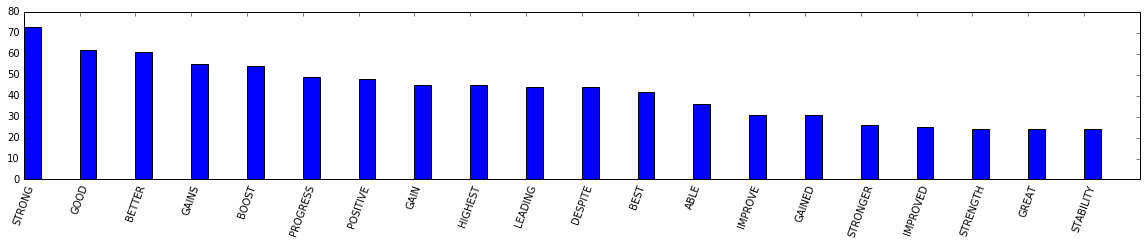

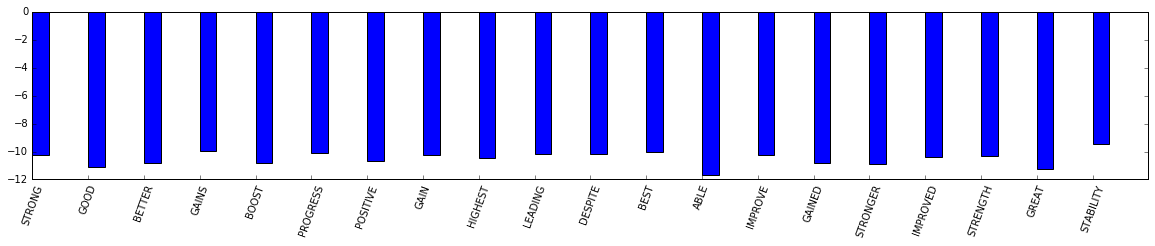

In [315]:
import numpy as np
import matplotlib.pyplot as plt

sorted_counts = sorted(mcd.pos_word_counts.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_counts)
print(sorted_counts[50][0])
print(mcd.intersection_pos[sorted_counts[50][0]])
print(compute_PMI(sorted_counts[100][1], overall_org, mcd.intersection_pos[sorted_counts[100][0]], l))

sorted_counts[0:50]

plt.figure(figsize=(20, 3))  # width:20, height:3
# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
plt.bar(range(len(sorted_counts[0:20])), [val[1] for val in sorted_counts[0:20]], align='edge', width=.3)
plt.xticks(range(len(sorted_counts[0:20])), [val[0] for val in sorted_counts[:20]])
plt.xticks(rotation=70)
plt.show()


PMIs = [compute_PMI(count[1], overall_org, mcd.intersection_pos[count[0]], l) for count in sorted_counts[0:20]]

plt.figure(figsize=(20, 3))  # width:20, height:3
# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
plt.bar(range(len(sorted_counts[0:20])), PMIs, align='edge', width=.3)
plt.xticks(range(len(sorted_counts[0:20])), [val[0] for val in sorted_counts[:20]])
plt.xticks(rotation=70)
plt.show()